Code to read survey results

Number of participants by region and language used.
The type of sample method used in the survey (simple, complex, etc.).
What is the survey representative of when you use the sample weights and when you don’t use the sample weights. This could be country, household, or individual.
The questions you would like to use in the thesis together with some descriptive statistics (for this you can omit considering the sample design and weights):
type of data: dichotomous; categorical (which categories); continuous (which range); open question (which language).
Correlation analysis

Data reading and Preparation:

In [177]:
import pandas as pd
import numpy as np
import openpyxl
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

In [2]:
def read_ods(filename):
    # Use pandas to read the ODS file. The `engine='odf'` parameter is necessary to read ODS files.
    # Adjust the `sheet_name` parameter as needed. By default, it reads the first sheet.
    df = pd.read_excel(filename, engine='odf')
    return df

# Define a function to replace "not numbered" with the value in "Variable Label"
def replace_not_numbered(row):
    if row["Question number\n (Questionnaire file)"] == "not numbered":
        return row["Variable Label\n (Data files)"]
    else:
        return row["Question number\n (Questionnaire file)"]

# Replace 'example.ods' with the path to your ODS file
filename = 'dataverse_files\Wave1\SCALAR_Coastal_Longitudinal_Study_Wave_1_map.ods'

# Read the ODS file
metaInfo = read_ods(filename)

# Initialize empty lists to store grouped response options
question_numbers = []
variable_labels = []
descriptions = []
response_options = []

# Loop through DataFrame rows
current_question = None
for index, row in metaInfo.iterrows():
    if not pd.isnull(row['Question number(Questionnaire file)']):
        # If it's a new question, store its details
        current_question = row['Question number(Questionnaire file)']
        question_numbers.append(row['Question number(Questionnaire file)'])
        variable_labels.append(row['Variable Label(Data files)'])
        descriptions.append(row['Description'])
        response_options.append([(row['Values'], row['Value labels'])])
    elif current_question is not None:
        # If it's a response option, add it to the previous question's response options
        response_options[-1].append((row['Values'], row['Value labels']))

# Create a new DataFrame with grouped response options
grouped_df = pd.DataFrame({
    'Question number(Questionnaire file)': question_numbers,
    'Variable Label(Data files)': variable_labels,
    'Description': descriptions,
    'Response Options': response_options
})

grouped_df

,Question number(Questionnaire file),Variable Label(Data files),Description,Response Options
0,ID,ID,Respondent ID to match respondents between waves,"[(nan, nan)]"
1,not numbered,Q0_age,Age,"[(1.0, 16-24), (2.0, 25-34), (3.0, 35-44), (4...."
2,not numbered,Q0_gender,What gender do you identify with?,"[(1.0, Male), (2.0, Female)]"
3,not numbered,Q0_race_US,What race do you self-identify as? (USA only),"[(1.0, White), (2.0, Black or African American..."
4,not numbered,Q0_ethnicity_ID,What ethnic group do you identify as? (Indones...,"[(1.0, Jawa), (2.0, Sunda), (3.0, Madura), (4...."
...,...,...,...,...
214,Q60,Q60_elder,Yes – adults over 70,"[(0.0, No), (1.0, Yes)]"
215,Q60,Q60_no,No,"[(0.0, No), (1.0, Yes)]"
216,Q60,Q60_not_say,Prefer not to say,"[(0.0, No), (1.0, Yes)]"
217,Q60a,Q60a_parent,Are you the parent or guardian of any children...,"[(0.0, No), (1.0, Yes)]"


In [3]:
#Wave 1
Survey_Responses = pd.read_csv("dataverse_files\Wave1\SCALAR_Coastal_Longitudinal_Study_Wave_1_NL.csv").set_index("ID")
CNDataWave1 = pd.read_csv("dataverse_files\Wave1\SCALAR_Coastal_Longitudinal_Study_Wave_1_CN.csv").set_index("ID")
IDDataWave1 = pd.read_csv("dataverse_files\Wave1\SCALAR_Coastal_Longitudinal_Study_Wave_1_ID.csv").set_index("ID")
USDataWave1 = pd.read_csv("dataverse_files\Wave1\SCALAR_Coastal_Longitudinal_Wave_1_US.csv").set_index("ID")

#Wave 2
NLDataWave2 = pd.read_csv("dataverse_files\Wave2\SCALAR_Coastal_Longitudinal_Study_Wave_2_NL.csv").set_index("ID")
CNDataWave2 = pd.read_csv("dataverse_files\Wave2\SCALAR_Coastal_Longitudinal_Study_Wave_2_CN.csv").set_index("ID")
IDDataWave2 = pd.read_csv("dataverse_files\Wave2\SCALAR_Coastal_Longitudinal_Study_Wave_2_ID.csv").set_index("ID")
USDataWave2 = pd.read_csv("dataverse_files\Wave2\SCALAR_Coastal_Longitudinal_Wave_2_US.csv").set_index("ID")

#Wave 2 Recontact
NLDataWave2rec = pd.read_csv("dataverse_files\Wave2_Recontact\SCALAR_Coastal_Longitudinal_Study_Recontact_NL.csv").set_index("ID")
CNDataWave2rec = pd.read_csv("dataverse_files\Wave2_Recontact\SCALAR_Coastal_Longitudinal_Study_Recontact_CN.csv").set_index("ID")
IDDataWave2rec = pd.read_csv("dataverse_files\Wave2_Recontact\SCALAR_Coastal_Longitudinal_Study_Recontact_ID.csv").set_index("ID")
USDataWave2rec = pd.read_csv("dataverse_files\Wave2_Recontact\SCALAR_Coastal_Longitudinal_Study_Recontact_US.csv").set_index("ID")

#Wave 3
NLDataWave3 = pd.read_csv("dataverse_files\Wave3\SCALAR_Coastal_Longitudinal_Study_Wave_3_NL.csv").set_index("ID")
CNDataWave3 = pd.read_csv("dataverse_files\Wave3\SCALAR_Coastal_Longitudinal_Study_Wave_3_CN.csv").set_index("ID")
IDDataWave3 = pd.read_csv("dataverse_files\Wave3\SCALAR_Coastal_Longitudinal_Study_Wave_3_ID.csv").set_index("ID")
USDataWave3 = pd.read_csv("dataverse_files\Wave3\SCALAR_Coastal_Longitudinal_Wave_3_US.csv").set_index("ID")

#Wave 4
NLDataWave4 = pd.read_csv("dataverse_files\Wave4\SCALAR_Coastal_Longitudinal_Study_Wave_4_NL.csv").set_index("ID")
CNDataWave4 = pd.read_csv("dataverse_files\Wave4\SCALAR_Coastal_Longitudinal_Study_Wave_4_CN.csv").set_index("ID")
IDDataWave4 = pd.read_csv("dataverse_files\Wave4\SCALAR_Coastal_Longitudinal_Study_Wave_4_ID.csv").set_index("ID")
USDataWave4 = pd.read_csv("dataverse_files\Wave4\SCALAR_Coastal_Longitudinal_Study_Wave_4_US.csv").set_index("ID")

#All waves
AllWave1 = pd.concat([NLDataWave1, CNDataWave1, IDDataWave1, USDataWave1])
AllWave2 = pd.concat([NLDataWave2, CNDataWave2, IDDataWave2, USDataWave2])
AllWave2rec = pd.concat([NLDataWave2rec, CNDataWave2rec, IDDataWave2rec, USDataWave2rec])
AllWave3 = pd.concat([NLDataWave3, CNDataWave3, IDDataWave3, USDataWave3])
AllWave4 = pd.concat([NLDataWave4, CNDataWave4, IDDataWave4, USDataWave4])

#All Data
AllData = pd.concat([AllWave1, AllWave2, AllWave2rec, AllWave3,AllWave4], axis=1,)

In [179]:
#Wave 1 - All data of NL
Survey_Responses = pd.read_csv("dataverse_files\SCALAR_Coastal_Longitudinal_Study_Wave_One_NL.csv").set_index("ID")

In [180]:
Survey_Overview  = pd.read_excel('Survey Questions Overview.xlsx', sheet_name='Wave 1', engine='openpyxl')
# Clean the survey questions dataframe to make it more usable for mapping
# Fill forward non-null ADICO Category values to apply them to all relevant rows, Specify the columns to forward fill excluding "Values" and "Value labels"
columns_to_ffill = [col for col in Survey_Overview.columns if col not in ["Values", "Value labels"]]

# Forward fill the specified columns
Survey_Overview[columns_to_ffill] = Survey_Overview[columns_to_ffill].ffill()
Survey_Overview = Survey_Overview.rename(columns={'ADICO Category': 'ADICO_Category'})

# Apply the function to replace "not numbered" with the value in "Variable Label"
Survey_Overview["Question number\n (Questionnaire file)"] = Survey_Overview.apply(replace_not_numbered, axis=1)
Survey_Overview['Value labels'] = Survey_Overview['Value labels'].astype(str)

# Set the index to {value of "Question number\n (Questionnaire file)"} + "_" + {str(value of "Values")}
Survey_Overview.set_index(Survey_Overview["Variable Label\n (Data files)"] + "_" + Survey_Overview["Values"].astype(str), inplace=True)
Survey_Overview.drop("ID_nan", inplace=True)
Survey_Overview.drop_duplicates(inplace=True)

question_answers_list = []
# Define a function to create the combined string
def combine_description_and_labels(group, question_answers_list, qnum):
    question_subset = Survey_Overview[Survey_Overview["Question number\n (Questionnaire file)"] == group["Question number\n (Questionnaire file)"].iloc[0]]
    # Check if it's the first row instance with the current "Question number\n (Questionnaire file)" column value
    first_instance_index = question_subset[question_subset.duplicated(subset=["Question number\n (Questionnaire file)"], keep="first")].index
    combined_string = ""
    # Concatenate the current row's "Description" and all "Value labels" values
    combined_string += str(group["Description"].iloc[0]) + ", " #+ "; ".join(group["Value labels"].astype(str))
    
    if first_instance_index.size != 0:
        first_description = question_subset["Description"].iloc[0]
        if first_description != group["Description"].iloc[0]:
         # If not the first instance, start with the first instance's "Description" column value
            combined_string += first_description

    question_answers_list = question_answers_list + [combined_string] * group.shape[0]  # Extend the list with the combined strings
    return question_answers_list

# Group by "Variable Label\n (Data files)" and apply the function to create the combined string
for group in Survey_Overview.groupby("Variable Label\n (Data files)",sort=False):
    question_answers_list = combine_description_and_labels(group[1], question_answers_list, group[1]["Question number\n (Questionnaire file)"].iloc[0])
Survey_Overview["question_answers_combined"] = question_answers_list


# Since the dataset has multiple rows per question for different value labels, we'll create a unique mapping
# Create the new mapping dictionary
question_adico_mapping = Survey_Overview[['question_answers_combined','ADICO_Category',"Variable Label\n (Data files)"]].drop_duplicates().set_index('question_answers_combined')

# Filter out questions that are categorized as Attributes, Conditions, or Aims for clarity in analysis
Attributes = list(set([Attribute for Attribute in question_adico_mapping[question_adico_mapping['ADICO_Category'].isin(["Attribute", "Attribute/Condition"])]['Variable Label\n (Data files)']]))
Conditions = list(set([Condition for Condition in question_adico_mapping[question_adico_mapping['ADICO_Category'].isin(["Condition",'Aim/Condition', "Attribute/Condition"])]['Variable Label\n (Data files)']]))
Aims = list(set([Aim for Aim in question_adico_mapping[question_adico_mapping['ADICO_Category'].isin(["Aim", "Aim/Condition"])]['Variable Label\n (Data files)']]))
Attcons = list(set([Attcon for Attcon in question_adico_mapping[question_adico_mapping['ADICO_Category'].isin(["Attribute", "Condition",'Aim/Condition', "Attribute/Condition"])]['Variable Label\n (Data files)']]))

chosen_aims = ["R06a_media_freq",  "R2_implementation_NM4", "R2_implementation_NM5", "R2_implementation_SM3"]

c:\Users\coolg\AppData\Local\Programs\Python\Python311\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


In [181]:
adico_training_data = Survey_Overview[["question_answers_combined", "ADICO_Category"]]
adico_training_data.drop_duplicates().to_csv('adico_training_data.csv')

Decision tree question selection:

In [182]:
adjusted_aim_responses = Survey_Overview.copy().dropna(axis=1)
for aim in adjusted_aim_responses.columns:
    if aim == "R06a_media_freq":
        adjusted_aim_responses.loc[adjusted_aim_responses[aim] > 3, aim] = 5
        adjusted_aim_responses.loc[adjusted_aim_responses[aim] <= 3, aim] = 1
    elif "implementation" in aim:
        adjusted_aim_responses.loc[adjusted_aim_responses[aim] > 5, aim] = 6
        adjusted_aim_responses.loc[adjusted_aim_responses[aim] <= 5, aim] = 1


Processing aim: R06a_media_freq: From the general media


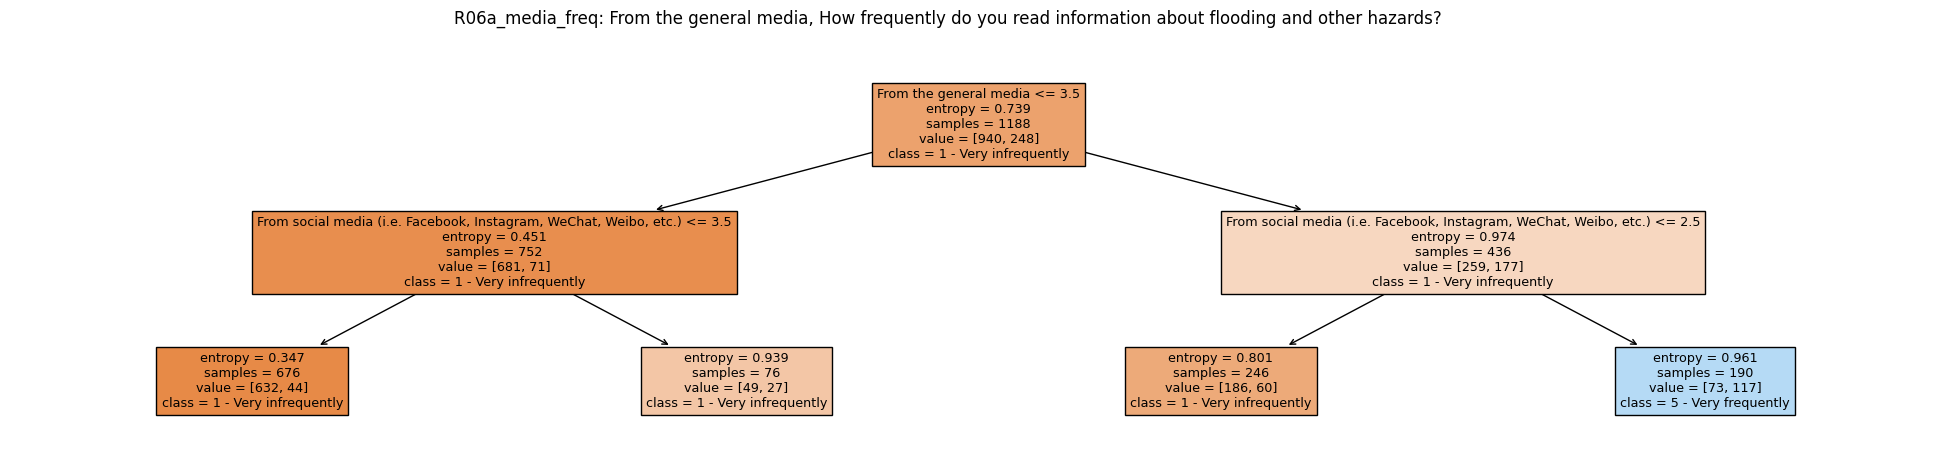

leafleft


,Aim,Aim_resp,total_aim,Condition1,Condition1_resp,Threshold1,filter1,Condition2,Condition2_resp,Threshold2,filter2
0,R06a_media_freq,1 - Very infrequently,940.0,Q31a_media_trust,"1 - Do not trust at all, 2, 3",3.5,681.0,R06b_social_media_freq,"4, 5 - Very frequently",3.5,632.0


Processing aim: R2_implementation_NM4: Being an active member in a community group aimed at making the community safer


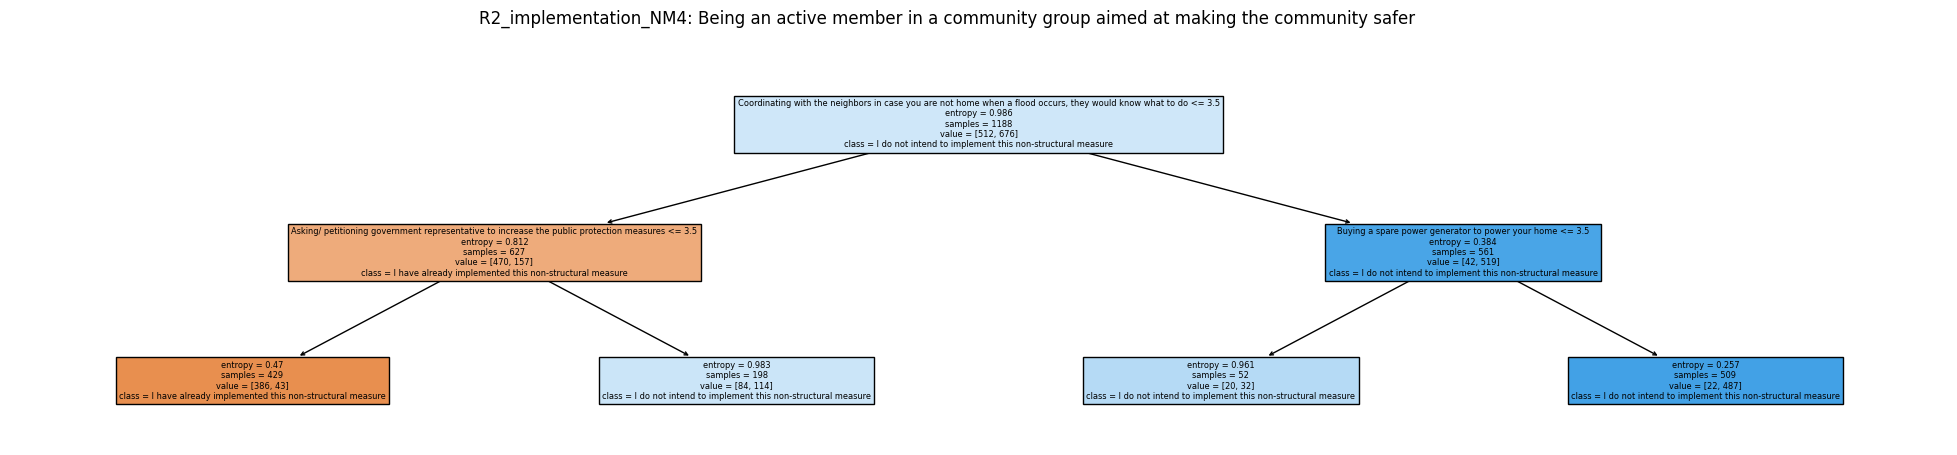

,Aim,Aim_resp,total_aim,Condition1,Condition1_resp,Threshold1,filter1,Condition2,Condition2_resp,Threshold2,filter2
0,R06a_media_freq,1 - Very infrequently,940.0,Q31a_media_trust,"1 - Do not trust at all, 2, 3",3.5,681.0,R06b_social_media_freq,"4, 5 - Very frequently",3.5,632.0
1,R2_implementation_NM4,I do not intend to implement this non-structur...,676.0,R2_implementation_NM5,I have not yet implemented this measure,3.5,519.0,R2_implementation_NM3,I have not yet implemented this measure,3.5,487.0


Processing aim: R2_implementation_NM5: Coordinating with the neighbors in case you are not home when a flood occurs, they would know what to do


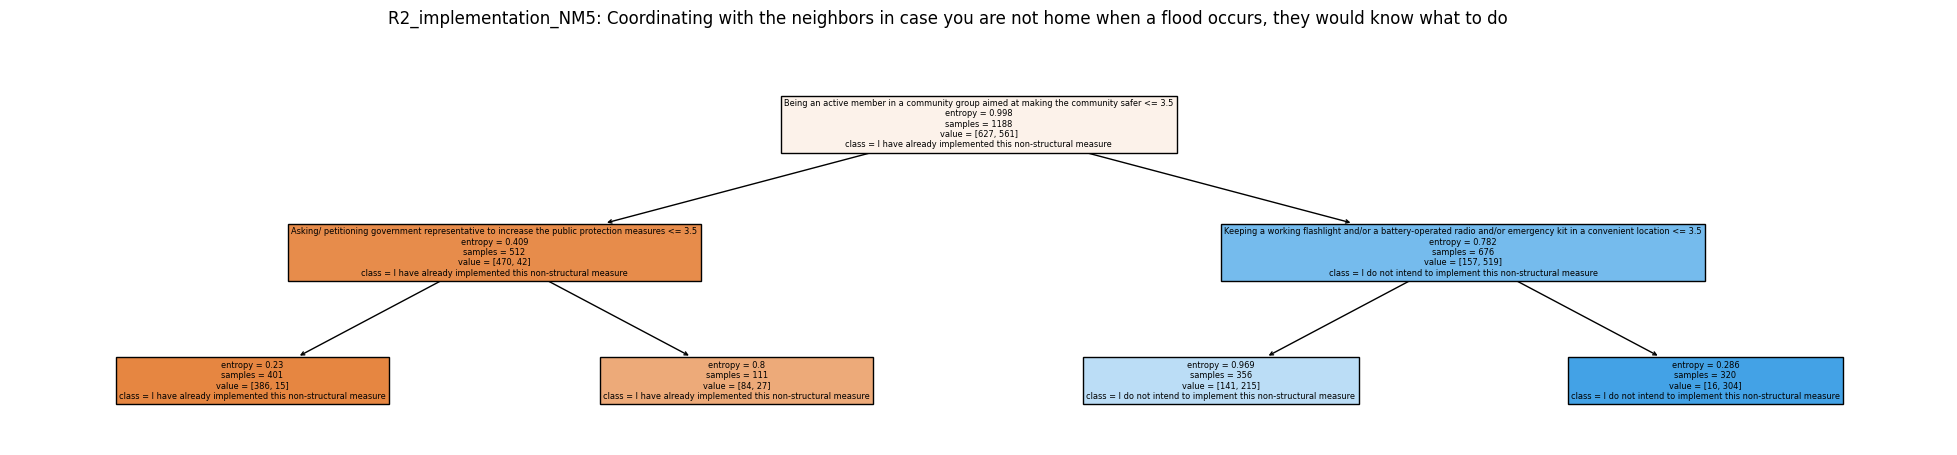

leafleft


,Aim,Aim_resp,total_aim,Condition1,Condition1_resp,Threshold1,filter1,Condition2,Condition2_resp,Threshold2,filter2
0,R06a_media_freq,1 - Very infrequently,940.0,Q31a_media_trust,"1 - Do not trust at all, 2, 3",3.5,681.0,R06b_social_media_freq,"4, 5 - Very frequently",3.5,632.0
1,R2_implementation_NM4,I do not intend to implement this non-structur...,676.0,R2_implementation_NM5,I have not yet implemented this measure,3.5,519.0,R2_implementation_NM3,I have not yet implemented this measure,3.5,487.0
2,R2_implementation_NM5,I have already implemented this non-structural...,627.0,R2_implementation_NM4,I have already implemented this non-structural...,3.5,470.0,R2_implementation_NM9,I have not yet implemented this measure,3.5,386.0


Processing aim: R2_implementation_SM3: Reconstructing or reinforcing the walls and/or the ground floor with water-resistant materials


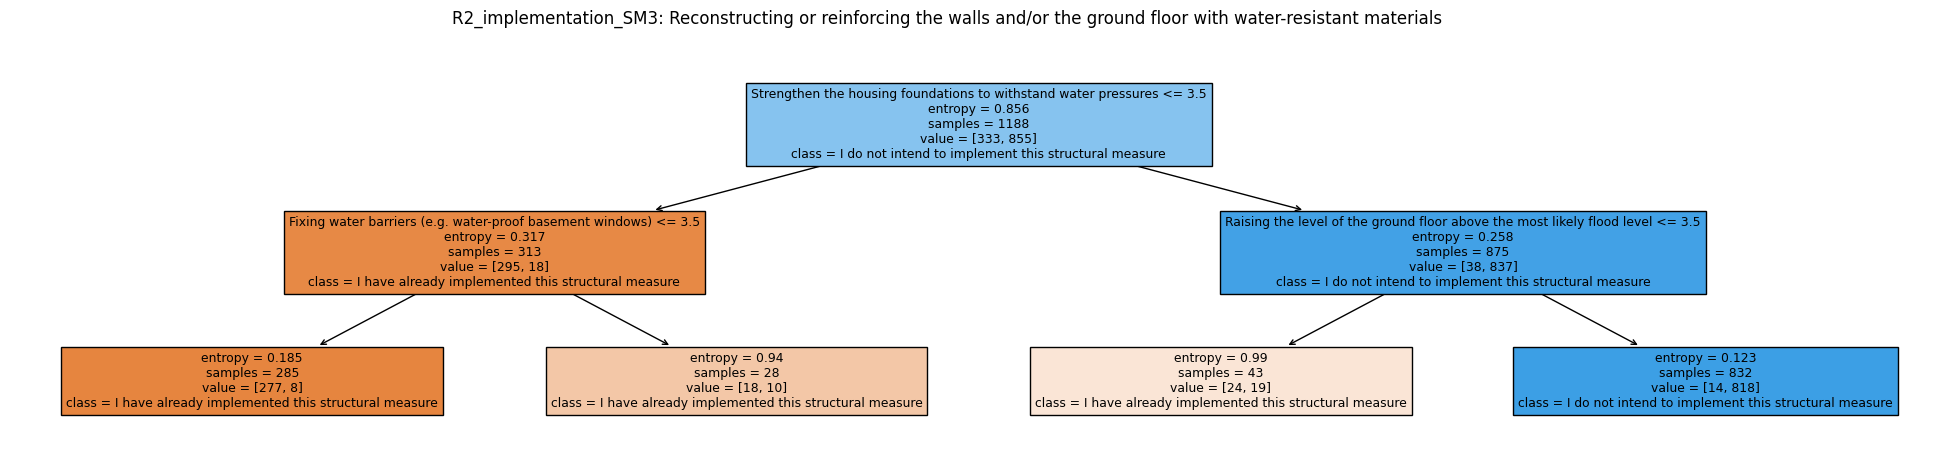

,Aim,Aim_resp,total_aim,Condition1,Condition1_resp,Threshold1,filter1,Condition2,Condition2_resp,Threshold2,filter2
0,R06a_media_freq,1 - Very infrequently,940.0,Q31a_media_trust,"1 - Do not trust at all, 2, 3",3.5,681.0,R06b_social_media_freq,"4, 5 - Very frequently",3.5,632.0
1,R2_implementation_NM4,I do not intend to implement this non-structur...,676.0,R2_implementation_NM5,I have not yet implemented this measure,3.5,519.0,R2_implementation_NM3,I have not yet implemented this measure,3.5,487.0
2,R2_implementation_NM5,I have already implemented this non-structural...,627.0,R2_implementation_NM4,I have already implemented this non-structural...,3.5,470.0,R2_implementation_NM9,I have not yet implemented this measure,3.5,386.0
3,R2_implementation_SM3,I do not intend to implement this structural m...,855.0,R2_implementation_SM2,I have not yet implemented this measure,3.5,837.0,R2_implementation_SM1,I have not yet implemented this measure,3.5,818.0


In [175]:
statement_questions = pd.DataFrame(columns = ['Aim', 'Aim_resp', 'total_aim', 'Condition1', 'Condition1_resp', 'Threshold1', 'filter1', 'Condition2', 'Condition2_resp', 'Threshold2', 'filter2'])
chosen_aims = ["R06a_media_freq",  "R2_implementation_NM4", "R2_implementation_NM5", "R2_implementation_SM3"]

for aim in chosen_aims:
       
    # Find the relevant row and value labels
    aimRow = Survey_Overview[Survey_Overview["Variable Label\n (Data files)"] == aim]
    aimRow0 = str(aimRow.at[aimRow.index[0], "Value labels"])
    aimRow1 = str(aimRow.at[aimRow.index[-1], "Value labels"])
    classes = [aimRow0,aimRow1]

    print(f"Processing aim: {aim}: {str(aimRow.at[aimRow.index[0], 'Description'])}")
    
    # Split the data
    X = adjusted_aim_responses.loc[:, ~adjusted_aim_responses.columns.isin([aim])].values
    Y = adjusted_aim_responses.loc[:, aim].values

    # Train/test split and decision tree classifier
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.05, random_state=100)
    clf_entropy = DecisionTreeClassifier(criterion='entropy', random_state=100, max_depth=2, min_samples_leaf=5)
    clf_entropy.fit(X_train, y_train)

    #Get a list of descriptions for all the condtions we test
    features = adjusted_aim_responses.loc[:, ~adjusted_aim_responses.columns.isin([aim])].columns
    feature_descs = [Survey_Overview[Survey_Overview["Variable Label\n (Data files)"] == feature.strip()]['Description'].iat[0] for feature in features if feature.strip() in list(Survey_Overview["Variable Label\n (Data files)"])]
    
    # Visualize the decision tree
    plt.figure(figsize=(25, 5))

    plot_tree(clf_entropy, filled=True, feature_names=feature_descs, class_names=classes)
    if "implementation" in aim: plt.suptitle(f"{aim}: {str(aimRow.at[aimRow.index[0], 'Description'])}")
    else: plt.suptitle(f"{aim}: {str(aimRow.at[aimRow.index[0], 'question_answers_combined'])}")
    
    plt.show()

    # 'clf_entropy' is your trained decision tree classifier
    tree = clf_entropy.tree_
    condition1 = features[tree.feature[0]]   # Get the condition used for the root node
    threshold1 = tree.threshold[0]  # get the threshold used on the root node
    
    # Retrieve the class counts at the root node
    aim_resp_count = tree.value[0][0]  # Gets the counts for each class
    
    # Find the majority class at the root node
    total_aim_count = aim_resp_count[np.argmax(aim_resp_count)]
    
    # Identify the leaves of the first condition
    condition1_indices = np.where(tree.feature != -2)[0][1:] #ignoring the first in the list because that is the root

    # Find the branch of condition1 with the least impurity (entropy)
    condition1_least_entropy_index = condition1_indices[np.argmin(tree.impurity[condition1_indices])]

    #Rows of question data for condition1
    condition1_rows = Survey_Overview[Survey_Overview['Variable Label\n (Data files)'] == condition1]

    leaf_is_left = tree.threshold[condition1_least_entropy_index - 1] == threshold1  # Determine if the leaf is on the "left"

    # Set 'in_thresh' based on whether the condition is met (leaf is within the threshold)
    if leaf_is_left:
        in_thresh = 0  # The leaf meets the threshold
        condition1_rows_of_leaf = condition1_rows[condition1_rows['Values'] <= threshold1]['Value labels']
    else:
        in_thresh = -1  # The leaf does not meet the threshold (falls outside the threshold)
        if "implementation" in condition1: 
            condition1_rows_of_leaf =  ["I have not yet implemented this measure"]
        else: 
            condition1_rows_of_leaf = condition1_rows[condition1_rows['Values'] > threshold1]['Value labels']

    # Get the majority class for the leaf with the least impurity
    majority_class_index = np.argmax(tree.value[condition1_least_entropy_index])
    majority_class_count = tree.value[condition1_least_entropy_index][0, majority_class_index]

    # Filter data for those meeting the condition
    condition_column = adjusted_aim_responses[condition1]
    filter1_count = len(Y[Y == y_train[0]])  # Sample size for those with the lowest entropy class
    filter2_count = len(condition_column[condition_column <= threshold1])  # Sample size within the threshold

    #Identify leaf indices (where feature is -2)
    leaf_indices = np.where(tree.feature == -2)[0]

    #find the leaf with the lowest entropy
    least_entropy_index = leaf_indices[np.argmin(tree.impurity[leaf_indices])]
    
    condition2_resp_count = tree.value[least_entropy_index][0][np.argmax(tree.value[least_entropy_index][0])]

    leaf_is_left = tree.feature[least_entropy_index - 1] != -2  # Determine if the leaf is on the "left"

    # Set 'in_thresh' based on whether the condition is met (leaf is within the threshold)
    if leaf_is_left: # The leaf meets the threshold      
        condition2_loc = least_entropy_index - 1
        condition2 = features[tree.feature[condition2_loc]]
        threshold2 = tree.threshold[condition2_loc]  # get the threshold used on the least entropy leaf
        #Rows of question data for this condition
        condition2_rows = Survey_Overview[Survey_Overview['Variable Label\n (Data files)'] == condition2] 
        condition2_rows_of_leaf = condition2_rows[condition2_rows['Values'] <= threshold2]['Value labels']
        print("leafleft")
    else:  # The leaf does not meet the threshold (falls outside the threshold)
        condition2_loc = least_entropy_index - 2
        condition2 = features[tree.feature[condition2_loc]]
        threshold2 = tree.threshold[condition2_loc]  # get the threshold used on the least entropy leaf
        #Rows of question data for this condition
        condition2_rows = Survey_Overview[Survey_Overview['Variable Label\n (Data files)'] == condition2]         
        condition2_rows_of_leaf = condition2_rows[condition2_rows['Values'] <= threshold2]['Value labels']

    if "implementation" in condition2: 
        condition2_rows_of_leaf = ["I have not yet implemented this measure"]
    else: 
        condition2_rows_of_leaf = condition2_rows[condition2_rows['Values'] > threshold2]['Value labels']



    # Create a new row with specified values
    new_row = {
        'Aim': aim,
        'Aim_resp': classes[majority_class_index],  # Class with the lowest entropy
        'total_aim': total_aim_count,
        'Condition1': condition1,
        'Condition1_resp': ", ".join(condition1_rows_of_leaf),
        'Threshold1': threshold1,
        'filter1': majority_class_count, 
        'Condition2': condition2, 
        'Condition2_resp': ", ".join(condition2_rows_of_leaf), 
        'Threshold2': threshold2, 
        'filter2': condition2_resp_count
    }
    # Using a new index to add a row directly
    ind = len(statement_questions)  # Determine the next index
    statement_questions.loc[ind] = new_row

    # Drop duplicates if needed
    statement_questions = statement_questions.drop_duplicates()
    display(statement_questions, )


# Save the DataFrame to a CSV file
statement_questions.to_csv("tree_selected_statements.csv", index=False)

AI - IG Statement generator:


In [265]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_groq import ChatGroq

import sys
import json
# Add the parent directory to the path
sys.path.append('..')

# Now you can import the config module
from config import groqkey

In [269]:
##Json Approach

statlist = []
models = ["gemma-7b-it", "llama3-8b-8192", "mixtral-8x7b-32768", "llama3-70b-8192"]
llm = ChatGroq(temperature=0, model=models[1], api_key=groqkey)

def ExampleCompletionFunction(request):
    system = """You are a text editor that transforms a collection of survey questions and responses into a structured statement depicting a group action influenced by a specific condition.
                You can only provide responses in JSON format. Here is an example response: "Attribute": "People", "Aim":"do this specific action", "Condition": "if this condition is met"
                Assume keys for the JSON object: Attribute, Aim, Condition
                How the provided data should be used: "Attribute": "Attribute", "Aim": "(converted Aim question and response)", "Condition": "(converted Condition question and response)"
                Keep them concise and do not change double-negatives
                """
    human = "{text}"
    prompt  = ChatPromptTemplate.from_messages([("system", system), ("human", human)])

    chain = prompt | llm
    response = chain.invoke({"text": request})
    return response.content

for row in statement_questions.index:
    print("")
    aimRow = Survey_Overview[Survey_Overview["Variable Label\n (Data files)"] == statement_questions.at[row, "Aim"]]
    conditionRow = Survey_Overview[Survey_Overview["Variable Label\n (Data files)"] == statement_questions.at[row, "Condition1"]]
    
    print("Out of",len(Survey_Responses),"survey responses,", int(statement_questions.at[row, 'total_aim']), "responded with:", statement_questions.at[row, 'Aim_resp'],  "to:", str(aimRow.at[aimRow.index[0], 'question_answers_combined']))
    print(int(statement_questions.at[row, 'filter1']), "of those people responded:", statement_questions.at[row, 'Condition1_resp'],  "to:", str(conditionRow.at[conditionRow.index[0], 'question_answers_combined']))
    
    aim_cond_stat = f"""Convert the following set of survey questions and responses into one statement:
                        Attribute: Households in the Netherlands
                        Aim question: '{str(aimRow.at[aimRow.index[0], 'question_answers_combined'])}' and response: '{statement_questions.at[row, 'Aim_resp']}'
                        Condition question: '{conditionRow.at[conditionRow.index[0], 'question_answers_combined']}' and response: '{statement_questions.at[row, 'Condition1_resp']}'
                        """
    
    # aim_cond_stat = f"""(Attribute: Households in the Netherlands),(Aim: {str(aimRow.at[aimRow.index[0], 'question_answers_combined'])} {statement_questions.at[row, 'Aim_resp']}), if (Condition: '{conditionRow.at[conditionRow.index[0], 'question_answers_combined']} {statement_questions.at[row, 'Condition1_resp']})"""

    IG_Statement = ExampleCompletionFunction(aim_cond_stat)
    print(IG_Statement)
    statlist.append(IG_Statement)


Out of 1251 survey responses, 940 responded with: 1 - Very infrequently to: From the general media, How frequently do you read information about flooding and other hazards?
681 of those people responded: 1 - Do not trust at all, 2, 3 to: From the general media, To what extent, if at all, do you trust information about flooding and other hazrds?
{
  "Attribute": "Households in the Netherlands",
  "Aim": "do not read information about flooding and other hazards very frequently",
  "Condition": "if they do not trust information about flooding and other hazards at all"
}

Out of 1251 survey responses, 676 responded with: I do not intend to implement this non-structural measure to: Being an active member in a community group aimed at making the community safer, Please indicate if you have already implemented any of these nonstructural measures or if you intend to do so in the future
519 of those people responded: I have not yet implemented this measure to: Coordinating with the neighbors i

In [273]:
df = pd.DataFrame(columns=["Attribute","Aim","Condition"])
for statementjson in statlist:
    try:
        # Parse the JSON string into a Python dictionary
        data_dict = json.loads(statementjson)
    except:
        # Parse the JSON string into a Python dictionary
        data_dict = json.loads("{"+statementjson.split('{')[1])        

    # Convert the dictionary to a DataFrame
    # Since we have only one record, we wrap it in a list to make a single-row DataFrame
    jsondf = pd.DataFrame([data_dict])
    df = pd.concat([df,jsondf])

display(df)

,Attribute,Aim,Condition
0,Households in the Netherlands,do not read information about flooding and oth...,if they do not trust information about floodin...
0,Households in the Netherlands,do not intend to implement non-structural meas...,if they have not yet implemented measures to c...
0,Households in the Netherlands,already implement non-structural measures to c...,if they are an active member in a community gr...
0,Households in the Netherlands,do not intend to reconstruct or reinforce the ...,if the housing foundations are not strengthene...


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

chosen_aims = ["R06a_media_freq",  "R2_implementation_NM4", "R2_implementation_NM5", "R2_implementation_SM3"]

responses_nadrop = aim_responses.dropna(axis=1)


for aim in chosen_aims:
    print(aim)
    X = responses_nadrop.loc[:, ~responses_nadrop.columns.isin([aim])].values
    Y = responses_nadrop.loc[:, aim].values

    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=100)
    
    # Create and train logistic regression model
    clf_logreg = LogisticRegression(max_iter=1000)
    clf_logreg.fit(X_train, y_train)
    
    # Make predictions
    y_pred = clf_logreg.predict(X_test)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(("Accuracy is"), accuracy)

    # Get feature names
    feature_names = responses_nadrop.loc[:, ~responses_nadrop.columns.isin([aim])].columns

    # Get coefficients
    coefficients = clf_logreg.coef_[0]

    # Create a DataFrame to display feature names and corresponding coefficients
    coef_df = pd.DataFrame({"Feature": feature_names, "Coefficient": coefficients})

    # Sort DataFrame by absolute coefficient values to identify most impactful features
    coef_df["Absolute Coefficient"] = coef_df["Coefficient"].abs()
    coef_df_sorted = coef_df.sort_values(by="Absolute Coefficient", ascending=False)

    # Display the top features impacting the prediction
    print("Top features impacting the prediction:")
    print(coef_df_sorted.head())



R06a_media_freq
Accuracy is 0.6666666666666666
Top features impacting the prediction:
                   Feature  Coefficient  Absolute Coefficient
33          Q14_early_warn    -0.137154              0.137154
131           Q46_dikes_NL     0.129086              0.129086
130  R07_adaptation_others    -0.102253              0.102253
46           R02_perc_prob    -0.084260              0.084260
5         Q1_home_ID_NL_US    -0.063724              0.063724
R2_implementation_NM4
Accuracy is 0.3333333333333333
Top features impacting the prediction:
                       Feature  Coefficient  Absolute Coefficient
5             Q1_home_ID_NL_US    -0.131175              0.131175
14                 Q8_move_out     0.096210              0.096210
140                Q58_savings    -0.081387              0.081387
46               R02_perc_prob     0.051327              0.051327
138  Q56_savings_change_future    -0.042332              0.042332
R2_implementation_NM5
Accuracy is 0.3333333333333333
T

In [ ]:
# Segment data by 'Q0_gender'
gender_groups = AllWave1.groupby('Q0_gender')

# Prepare a structure to hold the results of correlation analysis for each gender group
results = {}

# Iterate over each gender group and calculate correlations between selected conditions and aims
for gender, group in gender_groups:
    # Filter the group data for selected conditions and aims
    subgroup_data = group[selected_conditions + selected_aims].dropna()
    
    # Calculate the correlation matrix for the subgroup
    correlation_matrix = subgroup_data.corr()
    
    # Extract correlations between conditions and aims
    condition_aim_correlations = correlation_matrix.loc[selected_conditions, selected_aims]
    
    # Store the results
    results[gender] = condition_aim_correlations

# Due to the selection of a large number of conditions and aims, and for simplicity,
# let's display the results for the first gender group as an example
results[list(results.keys())[0]]


NameError: name 'selected_conditions' is not defined

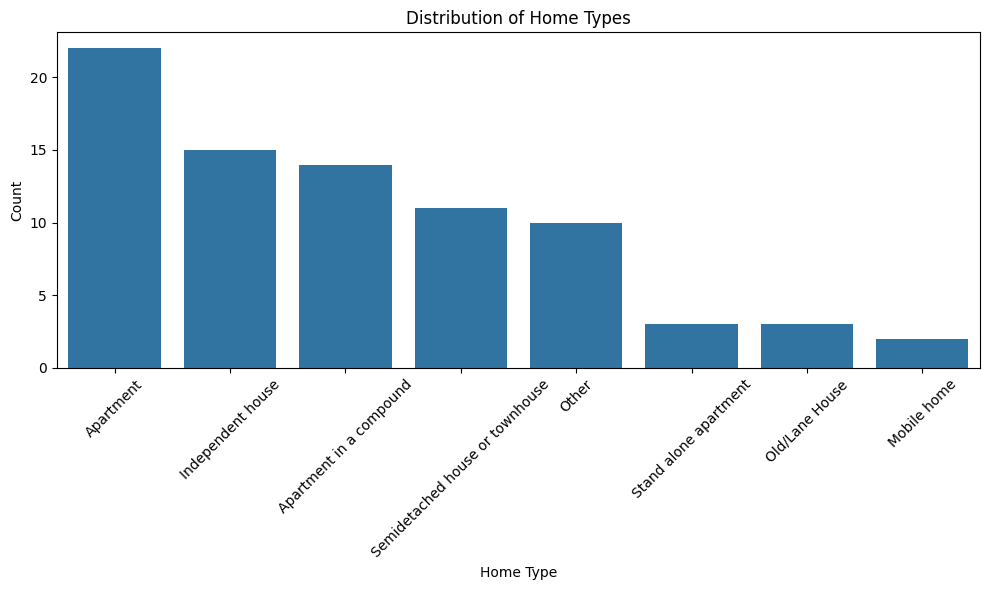

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Mapping numerical values to home types
home_type_mapping_ID_NL_US = {
    1.: 'Apartment',
    2.: 'Semidetached house or townhouse',
    3.: 'Independent house',
    4.: 'Mobile home',
    97.: 'Other'
}
home_type_mapping_CN = {
    1.: 'Old/Lane House',
    2.: 'Stand alone apartment',
    3.: 'Apartment in a compound',
    4.: 'Villa',
    5.:	"Serviced Apartment",
    97.:	"Other",
    98.:	"Don't know"
}

# Before applying the mapping for 'Q1_home_CN', ensure it's in the correct numeric format and handle NaN as necessary
AllWave1['Q1_home_ID_NL_US'] = AllWave1['Q1_home_ID_NL_US'].apply(pd.to_numeric, errors='coerce')

# Apply mapping for 'Q1_home_ID_NL_US' with the provided mapping
AllWave1['Q1_home_ID_NL_US'] = AllWave1['Q1_home_ID_NL_US'].map(home_type_mapping_ID_NL_US)

# Before applying the mapping for 'Q1_home_CN', ensure it's in the correct numeric format and handle NaN as necessary
AllWave1['Q1_home_CN'] = AllWave1['Q1_home_CN'].apply(pd.to_numeric, errors='coerce')

# Apply mapping for 'Q1_home_CN' with the provided mapping
AllWave1['Q1_home_CN'] = AllWave1['Q1_home_CN'].map(home_type_mapping_CN)

# Fill NaN values in 'Q1_home_ID_NL_US' with the values from 'Q1_home_CN_mapped'
AllWave1['Q1_home_ID_NL_US'] = AllWave1['Q1_home_ID_NL_US'].fillna(AllWave1['Q1_home_CN'])


# Visualise the distribution of home types
plt.figure(figsize=(10, 6))
sns.countplot(data=AllWave1, x='Q1_home_ID_NL_US', order=AllWave1['Q1_home_ID_NL_US'].value_counts().index)
plt.xticks(rotation=45)
plt.title('Distribution of Home Types')
plt.xlabel('Home Type')
plt.ylabel('Count')
plt.tight_layout()

plt.show()

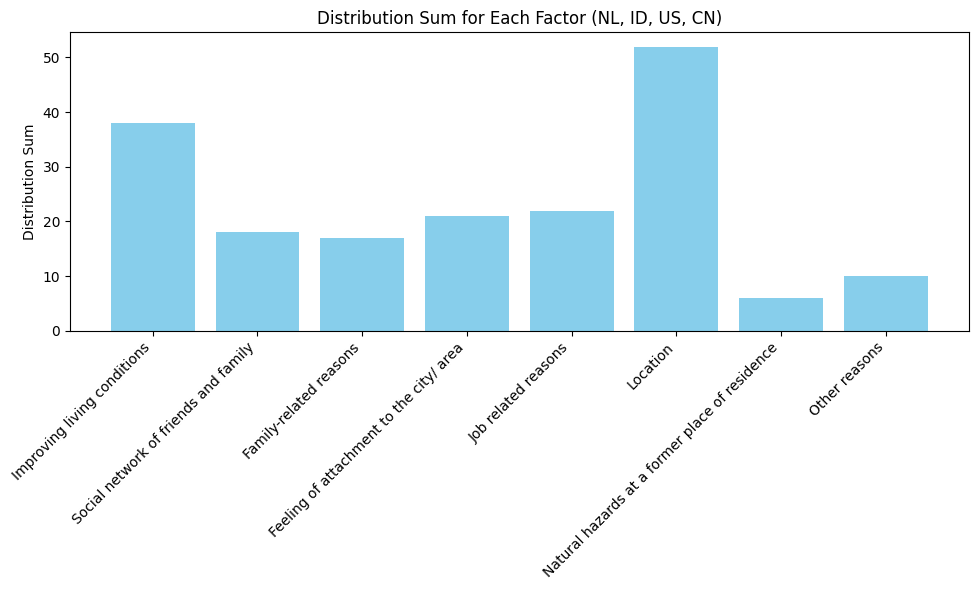

In [ ]:
# Calculate distribution sum for each factor
distribution_sums = []
factors = []

# Define mapping of response options to factors
factor_mapping = {
    'Improving living conditions': 'Q11_search_improve',
    'Social network of friends and family': 'Q11_search_social',
    'Family-related reasons': 'Q11_search_family',
    'Feeling of attachment to the city/ area': 'Q11_search_area',
    'Job related reasons': 'Q11_search_job',
    'Location': 'Q11_search_location',
    'Natural hazards at a former place of residence': 'Q11_search_hazard',
    'Other reasons': 'Q11_search_other',
}

for factor, column in factor_mapping.items():
    distribution_sum = AllWave1[column].sum()
    factors.append(factor)
    distribution_sums.append(distribution_sum)

# Create distribution plot
plt.figure(figsize=(10, 6))
plt.bar(factors, distribution_sums, color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Distribution Sum')
plt.title('Distribution Sum for Each Factor (NL, ID, US, CN)')
plt.tight_layout()
plt.show()

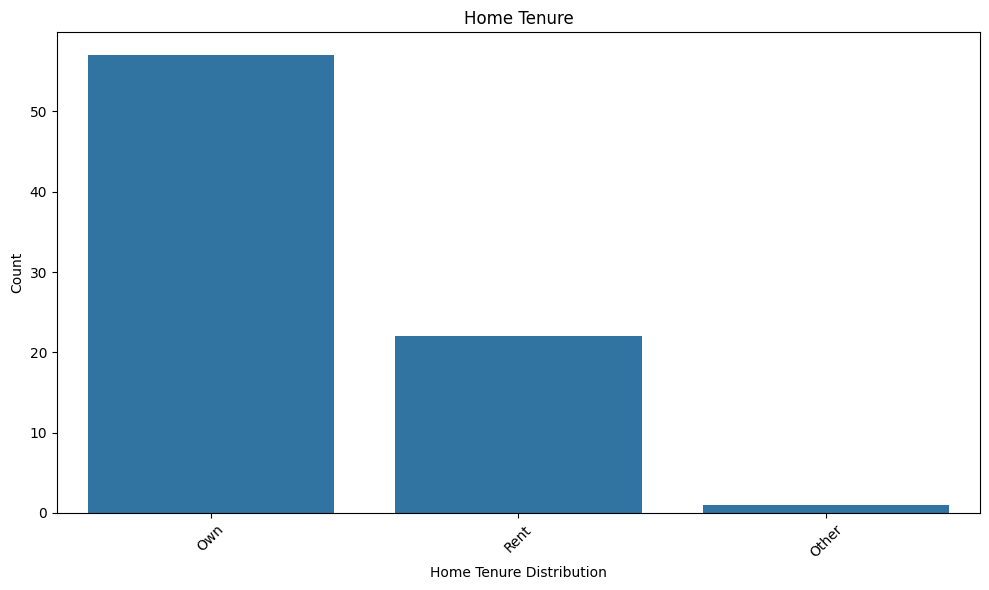

In [ ]:
# Mapping for home tenure
rent_own_mapping = {
    1: 'Rent',
    2: "Own",
    97: 'Other',
}

# Apply mapping
AllWave1['rent_own_mapping'] = AllWave1['Q5_home_tenure'].map(rent_own_mapping)

# Visualize the distribution of home tenure
plt.figure(figsize=(10, 6))
sns.countplot(data=AllWave1, x='rent_own_mapping', order=AllWave1['rent_own_mapping'].value_counts().index)
plt.xticks(rotation=45)
plt.title('Home Tenure')
plt.xlabel('Home Tenure Distribution')
plt.ylabel('Count')
plt.tight_layout()

plt.show()

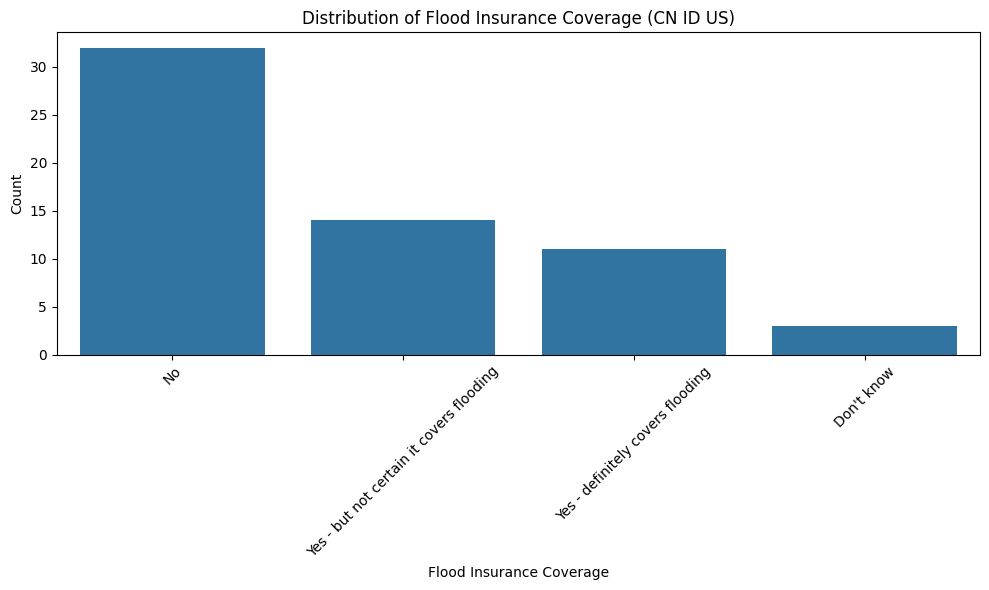

In [ ]:
# Mapping for flood insurance coverage
insurance_coverage_mapping = {
    1: 'Yes - definitely covers flooding',
    2: "Yes - but not certain it covers flooding",
    3: 'No',
    98: "Don't know"
}

# Apply mapping
AllWave1['insurance_coverage_mapped'] = AllWave1['Q41_ins_CN_ID_US'].map(insurance_coverage_mapping)

# Visualize the distribution of insurance coverage
plt.figure(figsize=(10, 6))
sns.countplot(data=AllWave1, x='insurance_coverage_mapped', order=AllWave1['insurance_coverage_mapped'].value_counts().index)
plt.xticks(rotation=45)
plt.title('Distribution of Flood Insurance Coverage (CN ID US)')
plt.xlabel('Flood Insurance Coverage')
plt.ylabel('Count')
plt.tight_layout()

plt.show()

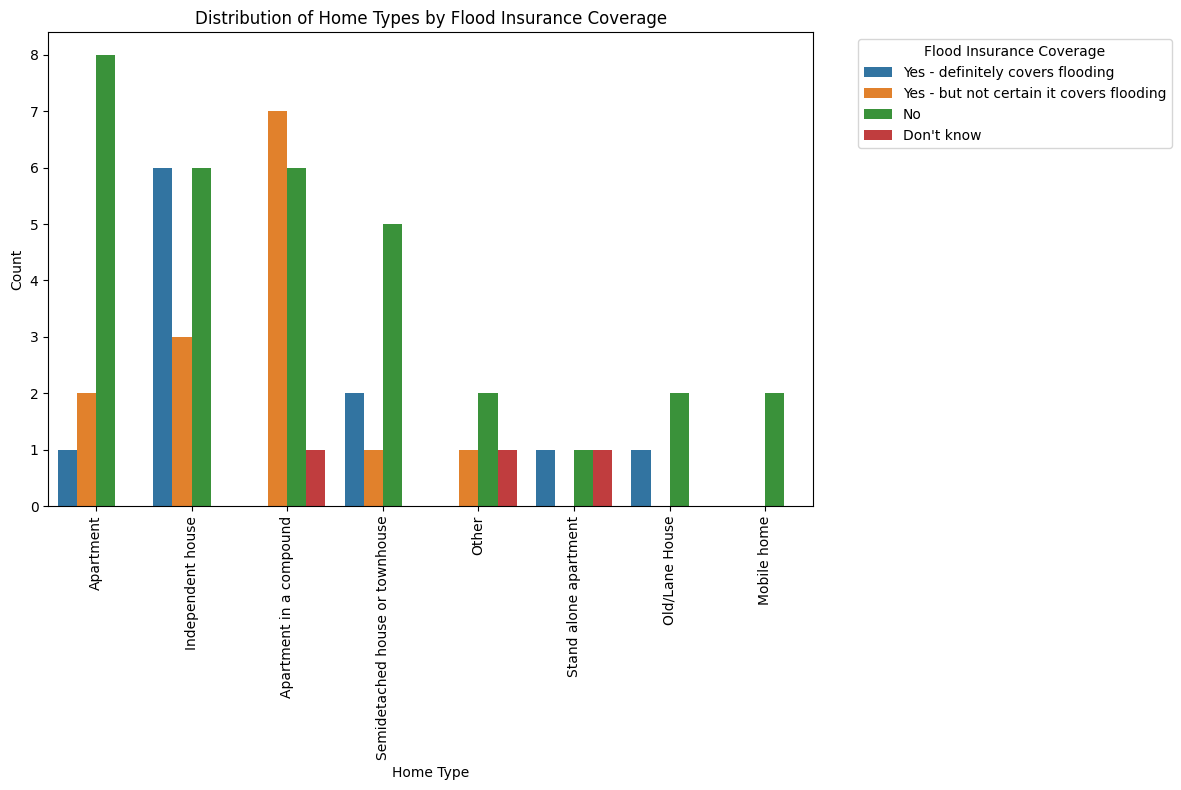

In [ ]:
# Assuming 'AllWave1' DataFrame already has the 'Q1_home_ID_NL_US' and 'Q41_ins_CN_ID_US' columns mapped to their textual descriptions

# Ensure the 'Q1_home_ID_NL_US' column is filled with 'Q1_home_CN' values for NaNs as you've done before
# Note: This step should already be done as per your previous message

# Visualize the distribution of home types with insurance coverage segmentation
plt.figure(figsize=(12, 8))
sns.countplot(data=AllWave1, x='Q1_home_ID_NL_US', hue='insurance_coverage_mapped', 
              order=AllWave1['Q1_home_ID_NL_US'].value_counts().index,
              hue_order=['Yes - definitely covers flooding', 'Yes - but not certain it covers flooding', 'No', "Don't know"])
plt.xticks(rotation=90)
plt.title('Distribution of Home Types by Flood Insurance Coverage')
plt.xlabel('Home Type')
plt.ylabel('Count')
plt.legend(title='Flood Insurance Coverage', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.show()


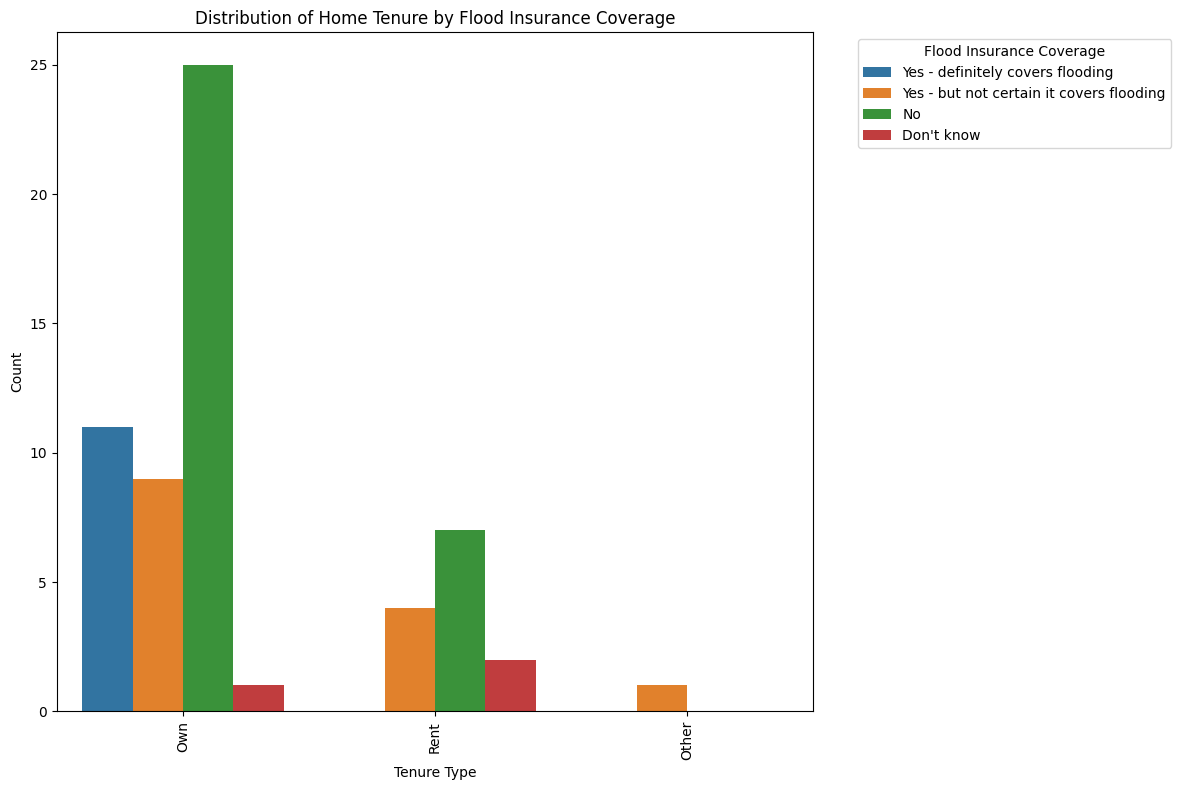

In [ ]:
# Assuming 'AllWave1' DataFrame already has the 'Q1_home_ID_NL_US' and 'Q41_ins_CN_ID_US' columns mapped to their textual descriptions

# Ensure the 'Q1_home_ID_NL_US' column is filled with 'Q1_home_CN' values for NaNs as you've done before
# Note: This step should already be done as per your previous message

# Visualize the distribution of home types with insurance coverage segmentation
plt.figure(figsize=(12, 8))
sns.countplot(data=AllWave1, x='rent_own_mapping', hue='insurance_coverage_mapped', order=AllWave1['rent_own_mapping'].value_counts().index,
              hue_order=['Yes - definitely covers flooding', 'Yes - but not certain it covers flooding', 'No', "Don't know"])
plt.xticks(rotation=90)
plt.title('Distribution of Home Tenure by Flood Insurance Coverage')
plt.xlabel('Tenure Type')
plt.ylabel('Count')
plt.legend(title='Flood Insurance Coverage', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.show()

In [ ]:
correlation_data = AllWave1[["Q18_flood_exp", "R05_worry", "R2_implementation_NM4"]].copy()
# Calculate Spearman correlation
correlation_matrix = correlation_data.corr(method='spearman')

correlation_matrix

,Q18_flood_exp,R05_worry,R2_implementation_NM4
Q18_flood_exp,1.000000,0.261944,-0.129233
R05_worry,0.261944,1.000000,-0.282069
R2_implementation_NM4,-0.129233,-0.282069,1.000000


In [ ]:
correlation_data = pd.DataFrame()
correlation_data['Q44_social_expectation'] = AllWave1['Q44_social_expectation'].copy()

# Create a new column that counts the occurrences of value == 1 in the specified columns
correlation_data['sum of household infrastructure change'] = AllWave1[['R2_implementation_SM1',
                                          'R2_implementation_SM2',
                                          'R2_implementation_SM3',
                                          'R2_implementation_SM4',
                                          'R2_implementation_SM5',
                                          'R2_implementation_SM6',
                                          'R2_implementation_SM7']].apply(lambda x: x.sum(), axis=1)

# Adjust 'Q41_ins_CN_ID_US' column based on the given condition
correlation_data['Intentional Flood insurance'] = AllWave1['Q41_ins_CN_ID_US'].apply(lambda x: 0 if x != 1 else x)

# Calculate Spearman correlation
correlation_matrix = correlation_data.corr(method='spearman')

correlation_matrix


,Q44_social_expectation,sum of household infrastructure change,Intentional Flood insurance
Q44_social_expectation,1.000000,-0.397670,0.338019
sum of household infrastructure change,-0.397670,1.000000,-0.263891
Intentional Flood insurance,0.338019,-0.263891,1.000000
